# Genetic Algorithm for UC

This notebook documents the development of a genetic algorithm solution to the unit commitment problem. It is roughly based on the paper from Kazarlis et al. (1996). The purpose of this project is to develop a benchmark solution for the UC problem, which can be compared with the performance of an AI system operator. 

## Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Economic dispatch

In order to calculate the fitness of a genotype, we need to be able to calculate the economic dispatch of a given schedule. This gives the outputs of the individual generators, as well as the amount of energy not served. 

In [2]:
def economic_dispatch(gen_info, schedule, demand):
    """
    Calculates the economic dispatch for a schedule (binary) and demand profile
    given a set of generator specifications. 
    
    Args:
        - gen_info (data frame): df of generator specs with fuel cost curves
        - schedule (array): array of shape (N, T) where N is the number of generators
        and T is the number of time periods. It is a binary description of the on/off
        schedules of the generators
        - demand profile (array): 1D array of size T with the absolute demands (MWh) for
        each time period.
    
    Returns: 
        - dispatch (array): array of shape (N, T) giving the absolute outputs of the 
        generators. 
        - ens (array): 1D array of size T giving the absolute difference between demand
        and supply.
    """
    T = len(demand)
    N = gen_info.shape[0]
    dispatch = np.zeros(shape=(T,N))
    ens = 0
    for t in range(T):
        schedule_t = schedule[t,:]
        demand_t = demand[t]
        disp_t, ens_t = economic_dispatch_period(gen_info, schedule_t, demand_t)
        dispatch[t,:] = disp_t
        ens += ens_t
    return dispatch, ens

def economic_dispatch_period(gen_info, schedule, demand):
    """
    The economic dispatch for a single period. Used in economic_dispatch() to get the
    ED for a whole schedule. 
    """
    action = np.where(schedule > 0, 1, 0)
    idx = np.where(np.array(action) == 1)[0]
    on_a = np.array(gen_info['a'][idx])
    on_b = np.array(gen_info['b'][idx])
    on_min = np.array(gen_info['min_output'][idx])
    on_max = np.array(gen_info['max_output'][idx]) 
    disp = np.zeros(gen_info.shape[0])
    ens = 0
    lambda_lo = 0
    lambda_hi = 30
    if np.sum(on_max) < demand:
        econ = on_max
        ens = demand - np.sum(on_max)
    elif np.sum(on_min) > demand:
        econ = on_min
        ens = np.sum(on_min) - demand
    else:
        econ = lambda_iteration(demand, lambda_lo,
                                lambda_hi, on_a, on_b,
                                on_min, on_max, epsilon=0.1)
    for (i, e) in zip(idx, econ):
        disp[i] = e
    return disp, ens
    
    
def lambda_iteration(load, lambda_low, lambda_high, a, b, mins, maxs, epsilon):
    """Calculate economic dispatch using lambda iteration. 
    
    Args:
        - load: the demand to be met 
        - lambda_low, lambda_high: initial lower and upper values for lambda
        - a: coefficients for quadratic load curves
        - b: constants for quadratic load curves
        - epsilon: stopping criterion for the iteration.  
    
    Returns: 
    a list of outputs for the generators.
    """
    num_gen = len(a)
    lambda_low = np.float(lambda_low)
    lambda_high = np.float(lambda_high)
    lambda_mid = 0
    total_output = sum(calculate_loads(lambda_high, a, b, mins, maxs, num_gen))
    while abs(total_output - load) > epsilon:
        lambda_mid = (lambda_high + lambda_low)/2
        total_output = sum(calculate_loads(lambda_mid, a, b, mins, maxs, num_gen))
        if total_output - load > 0:
            lambda_high = lambda_mid
        else:
            lambda_low = lambda_mid
    return calculate_loads(lambda_mid, a, b, mins, maxs, num_gen)

def calculate_loads(lm, a, b, mins, maxs, num_gen):
    """Calculate loads for all generators as a function of lambda.
    lm: lambda
    a, b: coefficients for quadratic curves of the form cost = a^2p + bp + c
    num_gen: number of generators
    
    Returns a list of individual generator outputs. 
    """
    powers = []
    for i in range(num_gen):
        p = (lm - b[i])/a[i]
        if p < mins[i]:
            p = mins[i]
        elif p > maxs[i]:
            p = maxs[i]
        powers.append(p)
    return powers

## Calculate fuel costs 

We can now calculate the operating costs of the dispatch, using the fuel cost curves given in the generator specifications. 

In [3]:
def calculate_fuel_costs(dispatch, gen_info):
    """
    Calculate the fuel costs over all the periods in a dispatch schedule 
    of dimension (T,N). 
    
    Args:
        - dispatch (array): an array of unit dispatches of dimension (T,N)
        - gen_info (data frame): generator specs
        
    Returns:
        - fuel_costs (array): array of length T with period fuel costs. 
    """
    T = dispatch.shape[0]
    fuel_costs = np.zeros(T)
    for t in range(T):
        dispatch_period = dispatch[t]
        costs_period = calculate_costs_period(dispatch_period, gen_info)
        fuel_costs[t] = np.sum(costs_period)
    return fuel_costs
        
def calculate_costs_period(outputs, gen_info, n_hrs=1):
    """Calculate production costs for units in a  given period. 
    Quadratic cost curves are of the form: cost = (a^2(x) + b(x) + c)*time_in_hours
    
    Args:
      - outputs: array of generating outputs
      - a, b, c: arrays of coefficients for quadratic cost curves
      - n_hours: resolution of settlement periods. 0.5 if half-hourly etc. 
    
    Outputs:
        - cost_list: a list of production costs for each unit. 
    """
    num_gen = gen_info.shape[0]
    a = np.array(gen_info['a'])
    b = np.array(gen_info['b'])
    c = np.array(gen_info['c'])
    costs = np.zeros(num_gen)
    for i in range(num_gen):
        if outputs[i] == 0:
            costs[i] = 0
        else:      
            cost_unit = n_hrs*(a[i]*(outputs[i]**2) + b[i]*outputs[i] + c[i])
            costs[i] = cost_unit
    return costs

## Calculate start costs

Here we calculate the start costs of a schedule. Clearly this is independent of the economic dispatch. It also requires that we know the operating status of the generators in the period **before** the schedule began. We will call this `init_status`. 

In [4]:
def calculate_start_costs(gen_info, schedule, init_status):
    """
    Calculate the start costs of a schedule given an initial status preceding 
    the schedule.
    
    Args:
        - gen_info (data frame): generator specs
        - schedule (array): array of shape (N, T) where N is the number of generators
        and T is the number of time periods. It is a binary description of the on/off
        schedules of the generators
        - init_status (array): array of size N, the unit statuses in the period
        preceding the schedule.     
    """
    T = schedule.shape[0]
    start_costs = np.zeros(T)
    for t in range(T):
        if t == 0:
            start_costs_period = calculate_start_costs_period(gen_info, schedule[t], init_status)
        else:
            start_costs_period = calculate_start_costs_period(gen_info, schedule[t], schedule[t-1])
        start_costs[t] = np.sum(start_costs_period)
    return(start_costs)

def calculate_start_costs_period(gen_info, status, prev_status):
    """
    Calculate the start costs between consecutive periods. Used in calculate_start_costs()
    to calculate start costs for an entire schedule. 
    
    Args:
        - gen_info (data frame): generator specs
        - status (array): status at time N 
        - prev_status (array): status at time N-1
        
    Returns:
        - start_costs (array): array of length N, the start costs for each unit. 
    """
    num_gen = gen_info.shape[0]
    cold_hrs = np.array(gen_info['cold_hrs'])
    cold_cost = np.array(gen_info['cold_cost'])
    hot_cost = np.array(gen_info['hot_cost'])
    
    action = np.where(status > 0, 1, 0)
    prev_action = np.where(prev_status > 0, 1, 0)
    idx = [list(map(list, zip(action, prev_action)))[i] == [1,0] for i in range(num_gen)]
    idx = np.where(idx)[0]
    
    start_costs = np.zeros(num_gen)
    
    for i in idx:
        if abs(prev_status[i]) <= -cold_hrs[i]: #####
            start_costs[i] = hot_cost[i]
        else:
            start_costs[i] = cold_cost[i]
    return start_costs

## Testing the cost functions

Here we demonstrate calculating the economic dispatch, start costs and lost load costs for an example schedule and demand profile produced by AISO. Further on we will use all these functions to define the fitness function of a genotype.

This is a useful bit of code in itself, as it can be used to test the operating costs of a **feasible** schedule. 

For the purposes of the GA, we still need to include a large penalty associated with constraint violations. 

In [5]:
gen_info = pd.read_csv('data/kazarlis_units_SP.csv')
num_gen = gen_info.shape[0]

# Define VOLL
VOLL = 1000

# Example demand and schedule 
demand = np.genfromtxt('example/example_demand.txt')
schedule = np.genfromtxt('example/example_schedule.txt')
init_status = np.array([8,8,-5,-5,-6,-3,-3,-1,-1,-1])

# Get economic dispatch and ENS
dispatch, ens = economic_dispatch(gen_info, schedule, demand)

# Calculate fuel costs
fuel_costs = np.sum(calculate_fuel_costs(dispatch, gen_info))

# Calculate lost load costs
lost_load_costs = np.sum(ens*VOLL)

# Calculate start costs
start_costs = np.sum(calculate_start_costs(gen_info, schedule, init_status))

total_cost = np.sum(fuel_costs) + np.sum(lost_load_costs) + np.sum(start_costs)

print("Fuel costs: ${}".format(fuel_costs))
print("Lost load costs: ${}".format(lost_load_costs))
print("Start costs: ${}".format(start_costs))
print()
print("TOTAL COSTS: ${}".format(total_cost))

FileNotFoundError: [Errno 2] File b'data/kazarlis_units_SP.csv' does not exist: b'data/kazarlis_units_SP.csv'

## Checking for constraint violations

For the GA problem, we also need to test schedules for constraint violations. For this problem, the only hard constraint is the minimum up/down times, since lost load is penalised at the value of lost load. We will simply count the number of times a generator has switched on or shut down too early, and penalise those events at a large cost which we will pass to the function.

In [36]:
def calculate_constraint_costs(gen_info, schedule, init_status, penalty):
    """
    Calculate the costs resulting from constraint violations. This is done by simply 
    counting the number of times a minimum up/down time constraint has been violated,
    and multiplying by the penalty.
    
    Args:
        - gen_info (data frame): generator specs
        - schedule (array): array of shape (N, T) where N is the number of generators
        and T is the number of time periods. It is a binary description of the on/off
        schedules of the generators
        - init_status (array): array of size N, the unit statuses in the period
        preceding the schedule.
        
    Returns:
        - constraint_costs (array): array of size T, giving the constraint costs for 
        each period.
    """
    T = schedule.shape[0]
    constraint_costs = np.zeros(T)
    for t in range(T):
        if t == 0:
            constraint_costs_period = calculate_constraint_costs_period(gen_info, schedule[t], init_status, penalty)
        else:
            constraint_costs_period = calculate_constraint_costs_period(gen_info, schedule[t], schedule[t-1], penalty)
        constraint_costs[t] = np.sum(constraint_costs_period)
    return(constraint_costs)

def calculate_constraint_costs_period(gen_info, status, prev_status, penalty):
    """
    Calculate the number of constraint violations between consecutive periods.
    
    Args:
        - gen_info (data frame): generator specs
        - status (array): status at time N 
        - prev_status (array): status at time N-1
        - penalty (float): the penalty ($) for each constraint violation
        
    Returns:
        - constraint_costs (float): the constraint costs for that period. 
    """
    num_gen = gen_info.shape[0]
    t_min_down = np.array(gen_info['t_min_down'])
    t_min_up = np.array(gen_info['t_min_up'])
    
    # Convert schedule to binary 
    action = np.where(status > 0, 1, 0)
    prev_action = np.where(prev_status > 0, 1, 0)
    
    min_down_count = 0 # count for minimum down time violations
    min_up_count = 0 # count for minimum up time violations
    
    # Minimum down time violations
    on_idx = [list(map(list, zip(action, prev_action)))[i] == [1,0] for i in range(num_gen)]
    on_idx = np.where(on_idx)[0]
    for i in on_idx:
        if abs(prev_status[i]) < t_min_down[i]:
            min_down_count += 1
    
    # Minimum up time violations
    off_idx = [list(map(list, zip(action, prev_action)))[i] == [0,1] for i in range(num_gen)]
    off_idx = np.where(off_idx)[0]
    for i in off_idx:
        if abs(prev_status[i]) < t_min_up[i]:
            min_up_count += 1
    
    total_count = min_down_count + min_up_count
    constraint_costs = total_count*penalty
    return constraint_costs

## Calculate schedule fitness

We will now write a function to calculate the fitness of a schedule with the above functions.

In [41]:
def calculate_schedule_fitness(schedule, **kwargs):
    """
    Fitness function
    """
    gen_info = kwargs.get('gen_info')
    demand = kwargs.get('demand')
    voll = kwargs.get('voll')
    init_status = kwargs.get('init_status')
    constraint_penalty = kwargs.get('constraint_penalty')
    
    # Get economic dispatch and ENS
    dispatch, ens = economic_dispatch(gen_info, schedule, demand)
    # Calculate fuel costs
    fuel_costs = np.sum(calculate_fuel_costs(dispatch, gen_info))
    # Calculate lost load costs
    lost_load_costs = np.sum(ens*voll)
    # Calculate start costs
    start_costs = np.sum(calculate_start_costs(gen_info, schedule, init_status))
    # Calculate constraint costs 
    constraint_costs = calculate_constraint_costs(gen_info, schedule, 
                                                  init_status, constraint_penalty)

    # Sum to get fitness
    fitness = np.sum(fuel_costs) + np.sum(lost_load_costs) + np.sum(start_costs) + np.sum(constraint_costs)
    
    return fitness

## Helper function: converting between binary and integer schedules

A useful function is going to be to convert back and forth between what we will call binary and integer schedules:

- Binary schedule: on/off represented by 1 and 0 
- Integer schedule: gives the number of periods the unit has been active (positive) or inactive (negative). 

This will allow us to perturb a binary schedule (say, change a 1 to a 0), then convert back to the integer schedule (which we need to do to calculate start costs and constraint violations). 

The conversion to binary is straightforward. Converting to integer schedules is a bit more complicated (and also requires us to know the `init_status`.

In [7]:
def convert_to_binary(integer_schedule):
    """
    Converts an integer-encoded schedule to a binary encoded one. 
    
    Args:
        - integer_schedule (array): a T by N array where each cell gives the
        on (positive) or off (negative) time for that generator.
        
    Returns:
        - binary_schedule (array): a T by N array where each cell indicates whether
        the generator is online (1) or offline (0).
    """
    binary_schedule = np.where(integer_schedule > 0, 1, 0)
    return binary_schedule

def convert_to_integer(binary_schedule, init_status):
    """
    Converts a binary-encoded schedule to an integer-encoded one. 
    
    This is an inelegant double for-loop over time periods and generators. 
    Essentially, at each time step we know the binary values for t-1 and t
    which we will denote as b0 and b1 respectively, as well as the integer value
    for t-1 which we denote as i0. The task is to find i1s for each generator 
    at each iteration.
    
    Args:
        - binary_schedule (array): a T by N array where each cell indicates whether
        the generator is online (1) or offline (0).
    
    Returns:
        - integer_schedule (array): a T by N array where each cell gives the
        on (positive) or off (negative) time for that generator.
    """
    T = binary_schedule.shape[0]
    num_gen = binary_schedule.shape[1]
    binary_init_status = np.where(init_status > 0, 1, 0) # binarised init_status
    integer_schedule = np.zeros((T, num_gen))
    
    for t in range(T):
        for n in range(num_gen):
            if t == 0: 
                i0 = init_status[n]
                b0 = binary_init_status[n]
            else: 
                i0 = integer_schedule[t-1,n]
                b0 = binary_schedule[t-1,n]
            b1 = binary_schedule[t,n]
                        
            # If both binary are the same (not turned on or off), then just add 1 or -1.  
            if b0==b1: # On in consecutive periods, or off in consecutive periods
                integer_schedule[t,n] = i0 + (1 if b1 > 0 else -1)
            # If turning off, set value to -1
            elif b0 > b1:
                integer_schedule[t,n] = -1
            else:
                integer_schedule[t,n] = 1
    return integer_schedule

## Genotype object

Having defined the relevant functions, we can now define the genotype class and the fitness function. This is an essential building block of the algorithm.

In [8]:
class Population(object):
    """
    A collection of genotypes.
    """
    def __init__(self, size):
        self.size = size
        self.num_used = 0
        self.genotypes = []
    
    def add_genotype(self, genotype):
        """
        Add a genotype to the list of genotypes. Increment num_used.
        """
        self.genotypes.append(genotype)
        self.num_used += 1
        
    def best_two_genotypes(self): 
        """
        Get the indexes of the best two genotypes (genotypes with best fitness (lowest cost)). 
         
        Returns a list with the two best genotypes. 
        """
        fitnesses = np.array([x.fitness for x in self.genotypes])
        best_idxs = np.argsort(fitnesses)[:2]
        return list(np.array(self.genotypes)[best_idxs])
    
    def reset(self):
        self.genotypes = []
        self.num_used = 0

class Genotype(object):
    """
    The genotype object holds a single (integer) schedule and its fitness. Several genotypes
    make up a population.
    """
    def __init__(self, schedule, **kwargs):
        self.schedule = schedule
        self.demand = kwargs.get('demand')
        self.gen_info = kwargs.get('gen_info')
        self.init_status = kwargs.get('init_status')
        self.voll = kwargs.get('voll')
        self.constraint_penalty = kwargs.get('constraint_penalty')
        
        # Calculate the fitness
        self.fitness = self.calculate_fitness()

    
    def calculate_fitness(self):
        """
        Calculate the fitness of a genotype which is the sum of the fuel costs, lost load costs,
        start costs and constraint violation costs for that schedule. 
        
        Returns:
            - fitness (float): fitness 
        """
        # Get economic dispatch and ENS
        dispatch, ens = economic_dispatch(self.gen_info, self.schedule, self.demand)
        # Calculate fuel costs
        fuel_costs = np.sum(calculate_fuel_costs(dispatch, self.gen_info))
        # Calculate lost load costs
        lost_load_costs = np.sum(ens*self.voll)
        # Calculate start costs
        start_costs = np.sum(calculate_start_costs(self.gen_info, self.schedule, self.init_status))
        # Calculate constraint costs 
        constraint_costs = calculate_constraint_costs(self.gen_info, self.schedule, 
                                                      self.init_status, self.constraint_penalty)
        
        # Sum to get fitness
        fitness = np.sum(fuel_costs) + np.sum(lost_load_costs) + np.sum(start_costs) + np.sum(constraint_costs)
        
        return fitness        

## Testing the population and genotype classes with mutation

We will try crudely generating a population by mutating the example schedule. We will use this as one of our genetic operators later.

In [9]:
def mutate(binary_schedule, probability):
    """
    Randomly change bits in a binary schedule.
    
    Each bit has a small probability of being switched.
    
    Args:
        - binary_schedule (array): a T x N array giving the on/off statuses 
        of generators
        - probability (float): probability of mutation (per bit)
        
    Returns:
        - binary_schedule (array): the altered binary schedule
    """
    T, num_gen = binary_schedule.shape
    random_matrix = np.random.uniform(0, 1, size=(T, num_gen))
    # Get boolean array for where mutations will occur 
    idx = np.where(random_matrix < probability)
    
    # Change bits according to index.
    binary_schedule[idx] = np.array([not x for x in binary_schedule[idx]])

    #     random_t = np.random.choice(binary_schedule.shape[0]) 
#     random_n = np.random.choice(binary_schedule.shape[1])
#     binary_schedule[random_t, random_n] = not binary_schedule[random_t, random_n]

    return binary_schedule

schedule = np.genfromtxt('example/example_schedule.txt')
binary_schedule = convert_to_binary(schedule)

# Initialise the population
pop = Population(10)

all_kwargs = {'demand': demand,
                   'gen_info': gen_info,
                   'init_status': init_status,
                   'voll': VOLL,
                   'constraint_penalty': constraint_penalty}

while pop.num_used < pop.size:
    # Perturb the binary schedule
    new_binary_schedule = mutate(binary_schedule, 0.01)
    # Convert to an integer schedule
    new_integer_schedule = convert_to_integer(new_binary_schedule, init_status)
    # Initialise the new genotype
    new_genotype = Genotype(new_integer_schedule, **all_kwargs)
    # Add the genotype to the population
    pop.add_genotype(new_genotype)
    
# Retrieve the two best genotypes
best = pop.best_two_genotypes()
[x.fitness for x in best]

NameError: name 'demand' is not defined

## Genetic operators: crossover and mutation

We have most of the pieces in place to run the genetic algorithm. All we need now is to develop some genetic operators to produce better offspring from the genotypes. We will begin with crossover and mutation operators. Both of these functions work in the space of binary schedules. After the operators are applied, they must be converted to integer schedules before being used to instantiate a genotype object.

In [10]:
def mutate(binary_schedule, mutation_probability):
    """
    Randomly change bits in a binary schedule.
    
    Each bit has a small probability of being switched.
    
    Args:
        - binary_schedule (array): a T x N array giving the on/off statuses 
        of generators
        - mutation_probability (float): probability of mutation (per bit)
        
    Returns:
        - mutated_binary_schedule (array): the altered binary schedule
    """
    T, num_gen = binary_schedule.shape
    random_matrix = np.random.uniform(0, 1, size=(T, num_gen))
    # Get boolean array for where mutations will occur 
    idx = np.where(random_matrix < mutation_probability)
    
    # Change bits according to index.
    binary_schedule[idx] = np.array([not x for x in binary_schedule[idx]])
    
    mutated_binary_schedule = binary_schedule

    return mutated_binary_schedule


def crossover(binary_schedule1, binary_schedule2, crossover_probability):
    """
    Crossover operator for the genetic algorithm.
    
    Randomly select a crossover point, and for each generator use schedule 1
    up to the crossover point, and schedule 2 past the crossover point.
    
    Args:
        - binary_schedule1, binary_schedule2 (array): binary schedules for the 
        two genotypes being combined.
        
    Returns:
        - offspring_binary_schedule (array): the new schedule
    """
    T, num_gen = binary_schedule1.shape
    
    # Choose a random crossover point
    crossover_point = np.random.choice(T)
    
    # Initialise the offspring binary schedules
    offspring_binary_schedule1 = np.copy(binary_schedule1)
    offspring_binary_schedule2 = np.copy(binary_schedule2)
    
    for n in range(num_gen):
        random = np.random.uniform(0, 1)
        if random < crossover_probability:
            offspring_binary_schedule1[0:crossover_point,n] = binary_schedule2[0:crossover_point,n]
            offspring_binary_schedule2[crossover_point:,n] = binary_schedule1[crossover_point:,n]

    return offspring_binary_schedule1, offspring_binary_schedule2

## Generate offspring 

Using the mutation and crossover functions, we can write a function to produce an offspring from two genotypes. This now works in the space of genotypes, taking genotype objects as input and outputting an offspring genotype.

In [11]:
def generate_offspring(genotype1, genotype2, **kwargs):
    """
    Use the crossover and mutation operators to produce an offspring from 2 genotypes.
    
    The crossover operator is applied with probability crossover_probability. The mutation
    operator is always applied, but the probability that a given bit is mutated is 
    determined by mutation_probability.
    
    Args:
        - genotype1, genotype2 (Genotype objects): the genotypes to be combined
        
    Returns: 
        - offspring (Genotype object)
    """
    crossover_probability = kwargs.get('crossover_probability')
    mutation_probability = kwargs.get('mutation_probability')
    init_status = kwargs.get('init_status')
    
    # Apply crossover with probability crossover_probability. Otherwise pick the best one. 
    random = np.random.uniform(0, 1)
    
    binary_schedule1 = convert_to_binary(genotype1.schedule)
    binary_schedule2 = convert_to_binary(genotype2.schedule)
    
    # Apply crossover
    offspring_binary_schedule1, offspring_binary_schedule2 = crossover(binary_schedule1, binary_schedule2, 
                                                                       crossover_probability)
    
    # Apply mutation
    offspring_binary_schedule1 = mutate(offspring_binary_schedule1, mutation_probability)
    offspring_binary_schedule2 = mutate(offspring_binary_schedule2, mutation_probability)
    
    # Convert to integer
    offspring_integer_schedule1 = convert_to_integer(offspring_binary_schedule1, init_status)
    offspring_integer_schedule2 = convert_to_integer(offspring_binary_schedule2, init_status)
    
    # Initialise genotype
    offspring1 = Genotype(offspring_integer_schedule1, **kwargs)
    offspring2 = Genotype(offspring_integer_schedule2, **kwargs)
    
    return offspring1, offspring2

## Genetic algorithm

We can define the genetic algorithm, which works as follows:

1. Initialise 2 random (or chosen) schedules. 
2. Initialise the population with these 2 schedules.
3. While the population is not at capacity, crossover the best schedules with some probability and apply the mutation, generating an offspring. Add the offspring to the population. 
4. Choose the best two offspring and make it `best_genotype`. 
5. Reset the population.
6. Repeat steps 2--6.
7. Return the `best_genotype`. 

In [12]:
def run_genetic_algorithm(number_of_generations, seed_schedule, **kwargs):
    """
    Run the genetic algorithm. 
    """
    # Retrieve variables
    mutation_probability = kwargs.get('mutation_probability')
    init_status = kwargs.get('init_status')
    pop_size = kwargs.get('pop_size')
    
    # Initialise the best_genotype with the seed schedule. 
    best_genotype1 = Genotype(seed_schedule, **kwargs)
    
    # Mutate the best_genotype schedule to get second Genotype for population
    binary_schedule = convert_to_binary(seed_schedule)
    mutated_binary_schedule = mutate(binary_schedule, mutation_probability)
    mutated_integer_schedule = convert_to_integer(mutated_binary_schedule, init_status)
    best_genotype2 = Genotype(mutated_integer_schedule, **all_kwargs)
    
    # Initialise the population
    pop = Population(pop_size)
    
    for g in range(number_of_generations):
        # Always add the best genotype
        pop.add_genotype(best_genotype1)
        
        while pop.num_used < pop.size:
            # Create a new offspring
            offspring1, offspring2 = generate_offspring(best_genotype1, best_genotype2, **all_kwargs)
            pop.add_genotype(offspring1)
            pop.add_genotype(offspring2)
        
        # Update the best genotpyes.
        best_genotype1, best_genotype2 = pop.best_two_genotypes()
        
        # Reset the population
        pop.reset()
        
        print("Best fitness at iteration {0}: {1}".format(g, best_genotype1.fitness))
        
    return best_genotype1

## Testing the genetic algorithm

We will now do a short test of the genetic algorithm so far. 

In [13]:
demand = np.genfromtxt('data/kazarlis_demand.txt')
gen_info = pd.read_csv('data/kazarlis_units.csv')
init_status = gen_info.status

# Supply the kwargs
all_kwargs = {'demand': demand,
              'gen_info': gen_info,
              'init_status': init_status,
              'voll': 1e3,
              'constraint_penalty': 1e4,
              'mutation_probability': 0.01,
              'crossover_probability': 0.5,
              'pop_size': 50}

# Set the number of generations
number_of_generations = 10

# Number of generators and time periods
T = demand.size
num_gen = gen_info.shape[0]

# Get a random schedule to begin with
random_schedule = np.random.choice(2, size = (T, num_gen))
init_status = all_kwargs.get('init_status')
seed_schedule = convert_to_integer(random_schedule, init_status)

best_genotype = run_genetic_algorithm(number_of_generations, seed_schedule, **all_kwargs)
best_genotype.fitness

Best fitness at iteration 0: 9318203.227991194
Best fitness at iteration 1: 8718479.066065276
Best fitness at iteration 2: 8216241.966374464
Best fitness at iteration 3: 7613482.073994465
Best fitness at iteration 4: 7059721.191374172
Best fitness at iteration 5: 6564633.199132013
Best fitness at iteration 6: 6087014.124164369
Best fitness at iteration 7: 5513347.312354548
Best fitness at iteration 8: 5126960.4194173
Best fitness at iteration 9: 4653001.091636041


4653001.091636041

## Further improvements

The performance of the genetic algorithm at this stage is satisfactory (there is clear evidence of training) but not great. The described algorithm is a very general approach, and we can employ some problem-specific operators to improve adaptation. These ideas come from Kazarlis et al. (1996):

- Swap-window operator
- Window-mutation operator
- Swap-mutation operator
- Swap-window hill-climb operator

In addition, we can investigate several other ideas:

- Incrementing the constraint penalty
- Multi-point crossover
- Roulette wheel parent selection

## Swap window operator

This operator chooses 2 generators at random and a random time window. The schedules for the two units in this window are swapped.

In [14]:
def swap_window(binary_schedule):
    """
    The swap window operator.
    
    Takes a random time window in the schedule and 2 random units and swaps
    the schedules of the 2 units between these points. 
    
    Args:
        - binary_schedule (array): the schedule to which the operator 
        will be applied.
        
    Returns:
        - new_binary_schedule (array): the altered binary schedule.
    """
    T, num_gen = binary_schedule.shape
    
    # Choose a time window
    random_window = np.random.choice(np.arange(T), size=2, replace=False)
    random_window.sort()
    
    # Choose 2 generators
    random_gens = np.random.choice(np.arange(num_gen), size=2, replace=False)
        
    # Copy the schedule
    new_binary_schedule = np.copy(binary_schedule)
    
    # Copy the first schedule to swap
    temp = np.copy(binary_schedule[random_window[0]:random_window[1],random_gens[0]])
    
    new_binary_schedule[random_window[0]:random_window[1],random_gens[0]] = new_binary_schedule[random_window[0]:random_window[1],random_gens[1]]
    new_binary_schedule[random_window[0]:random_window[1],random_gens[1]] = temp
    
    return new_binary_schedule

## Window-mutation operator 

This operator chooses a unit at random and a random time window, then changes all the bits in this period to either 0 or 1. 

In [15]:
def window_mutation(binary_schedule):
    """
    Window mutation operator.
    
    Takes a random unit and time window and a binary schedule and changes
    all bits to either 0 or 1 (randomly). 
    
    Args:
        - binary_schedule (array): the schedule to which the operator 
        will be applied.
        
    Returns:
        - new_binary_schedule (array): the altered binary schedule.
    """
    T, num_gen = binary_schedule.shape
    
    # Choose a time window
    random_window = np.random.choice(np.arange(T), size=2, replace=False)
    random_window.sort()
    
    # Choose generator
    random_gen = np.random.choice(np.arange(num_gen))
    
    # Choose 0 or 1
    zero_or_one = np.random.choice(np.arange(2))
    
    new_binary_schedule = binary_schedule
    
    # Change to 0 or 1 in random window for random generator
    new_binary_schedule[random_window[0]:random_window[1],random_gen] = zero_or_one
    
    return new_binary_schedule

## Updated offspring generator

We will now include the new operators in our function to generate offspring. The operators will be applied with probabilities given in the kwargs.


In [19]:
def generate_offspring(genotype1, genotype2, **kwargs):
    """
    Use the crossover and mutation operators to produce an offspring from 2 genotypes.
    
    The crossover operator is applied with probability crossover_probability. The mutation
    operator is always applied, but the probability that a given bit is mutated is 
    determined by mutation_probability.
    
    Args:
        - genotype1, genotype2 (Genotype objects): the genotypes to be combined
        
    Returns: 
        - offspring (Genotype object)
    """
    crossover_probability = kwargs.get('crossover_probability')
    mutation_probability = kwargs.get('mutation_probability')
    swap_window_probability = kwargs.get('swap_window_probability')
    window_mutation_probability = kwargs.get('window_mutation_probability')
    init_status = kwargs.get('init_status')
    
    # Apply crossover with probability crossover_probability. Otherwise pick the best one. 
    random = np.random.uniform(0, 1)
    
    binary_schedule1 = convert_to_binary(genotype1.schedule)
    binary_schedule2 = convert_to_binary(genotype2.schedule)
    
    # Apply crossover
    offspring_binary_schedule1, offspring_binary_schedule2 = crossover(binary_schedule1, binary_schedule2, 
                                                                       crossover_probability)
    
    # Apply mutation
    offspring_binary_schedule1 = mutate(offspring_binary_schedule1, mutation_probability)
    offspring_binary_schedule2 = mutate(offspring_binary_schedule2, mutation_probability)
    
    # Apply swap window operator
    r1, r2 = np.random.uniform(0, 1, size=2)
    if r1 < swap_window_probability:
        offspring_binary_schedule1 = swap_window(offspring_binary_schedule1)
    if r2 < swap_window_probability:
        offspring_binary_schedule2 = swap_window(offspring_binary_schedule2)
        
    # Apply window mutation operator
    r1, r2 = np.random.uniform(0, 1, size=2)
    if r1 < window_mutation_probability:
        offspring_binary_schedule1 = window_mutation(offspring_binary_schedule1)
    if r2 < window_mutation_probability:
        offspring_binary_schedule2 = window_mutation(offspring_binary_schedule2)
        
    # Convert to integer
    offspring_integer_schedule1 = convert_to_integer(offspring_binary_schedule1, init_status)
    offspring_integer_schedule2 = convert_to_integer(offspring_binary_schedule2, init_status)
    
    # Initialise genotype
    offspring1 = Genotype(offspring_integer_schedule1, **kwargs)
    offspring2 = Genotype(offspring_integer_schedule2, **kwargs)
    
    return offspring1, offspring2

## Testing the updated genetic algorithm

In [22]:
# Supply the kwargs
all_kwargs = {'demand': demand,
              'gen_info': gen_info,
              'init_status': init_status,
              'voll': 1e3,
              'constraint_penalty': 1e4,
              'mutation_probability': 0.01,
              'crossover_probability': 0.5,
              'swap_window_probability': 0.3,
              'window_mutation_probability': 0.3,
              'pop_size': 50}

# Set the number of generations
number_of_generations = 100

# Number of generators and periods
num_gen = gen_info.shape[0]
T = demand.size

# Get a random schedule to begin with
random_schedule = np.random.choice(2, size = (T, num_gen))
init_status = all_kwargs.get('init_status')
seed_schedule = convert_to_integer(random_schedule, init_status)

best_genotype = run_genetic_algorithm(number_of_generations, seed_schedule, **all_kwargs)

Best fitness at iteration 0: 5802091.574589707
Best fitness at iteration 1: 3277562.554027458
Best fitness at iteration 2: 2393328.618224608
Best fitness at iteration 3: 1998188.3965910731
Best fitness at iteration 4: 1660822.557480597
Best fitness at iteration 5: 1286270.3471582262
Best fitness at iteration 6: 1170228.676696749
Best fitness at iteration 7: 1128925.6164825964
Best fitness at iteration 8: 1027160.6570172613
Best fitness at iteration 9: 925140.2850891664
Best fitness at iteration 10: 882162.7025923993
Best fitness at iteration 11: 856148.2955076867
Best fitness at iteration 12: 822104.6472341717
Best fitness at iteration 13: 804973.5646481583
Best fitness at iteration 14: 762536.2873582515
Best fitness at iteration 15: 739351.1410650143
Best fitness at iteration 16: 722347.7179564737
Best fitness at iteration 17: 697544.3103304745
Best fitness at iteration 18: 690606.6148752457
Best fitness at iteration 19: 689917.4909987451
Best fitness at iteration 20: 688747.976303594

## Plotting results

We can easily plot the resulting schedule. We need to calcualte the economic dispatch again. 

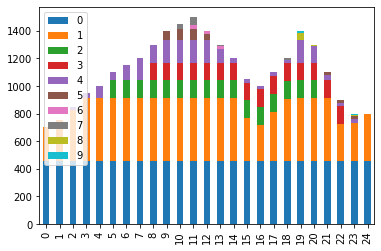

In [33]:
# Calculate ED for the best schedule
ed = economic_dispatch(gen_info, best_genotype.schedule, demand)

# Plot data frame 
df = pd.DataFrame(ed[0])
df.plot(kind='bar', stacked=True)
plt.show()

We already find a significant improvement as compared with the more general version tried above.

## Hill-climb operators

In the Kazarlis et al. (1996) paper, significant improvements were achieved by applying to 'hill-climb' operators. These are applied once per generation only to the best genotype of that generation.

In [68]:
def swap_mutation_operator(binary_schedule, **kwargs):
    """
    
    *** 24/01/20 LOOK AT THIS IN MORE DETAIL *** 
    
    The swap mutation operation. 
    
    Each hour, randomly choose to either swap bits between two 
    random generators, or change a random generator's status (on/off).
    
    This is applied only to the best genotype each generation.
    """
    T, num_gen = binary_schedule.shape
    new_binary_schedule = np.copy(binary_schedule)
    
    init_status = kwargs.get('init_status')
    
    # initiate best schedule and best fitness
    best_schedule = binary_schedule
    best_fitness = calculate_schedule_fitness(convert_to_integer(binary_schedule, init_status), **kwargs)
    
    for t in range(T):
        new_binary_schedule = np.copy(best_schedule)
        
        # Apply operator
        random = np.random.uniform(0,1)
        if random < 0.5:
            r1, r2 = np.random.choice(np.arange(num_gen), size=2, replace=False)
            temp = np.copy(new_binary_schedule[t, r1])
            new_binary_schedule[t, r1] = new_binary_schedule[t, r2]
            new_binary_schedule[t, r2] = temp
        else:
            r = np.random.choice(np.arange(num_gen))
            new_binary_schedule[t, r] = not new_binary_schedule[t, r]
            
        # Calculate fitness of new schedule
        new_fitness = calculate_schedule_fitness(convert_to_integer(new_binary_schedule, init_status), **kwargs)
        
        # Reassign best fitness and schedule 
        if new_fitness > best_fitness:
            best_schedule = new_binary_schedule
            best_fitness = new_fitness
            
    return best_schedule

## Testing the swap-mutation operator

In [69]:
binary_schedule = convert_to_binary(best_genotype.schedule)

# Old schedule fitness
print(calculate_schedule_fitness(best_genotype.schedule, **all_kwargs))

# New schedule and fitness
new_schedule = swap_mutation_operator(binary_schedule, **all_kwargs)
print(calculate_schedule_fitness(convert_to_integer(binary_schedule, init_status), **all_kwargs) )

577691.3251151197
577691.3251151197
